In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 200
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

# Secondary Eclipse Spectroscopy  

The `coronagraph` model can be used to model exoplanet observations using telescopes that don't even have a coronagraph. Here we will walk through a few examples of how to simulate secondary eclipse spectroscopy using the generic telescope noise modeling tools available with the `coronagraph` package. 

In [3]:
import coronagraph as cg
print(cg.__version__)

0.0.3


## Earth in Emission

Let's start out by loading a model spectrum of the Earth:

In [4]:
lam, tdepth, fplan, fstar = cg.get_earth_trans_spectrum()

Now we'll define the telescope/instrument parameters for our simulation. Let's go big for this demo and use a 15 meter space telescope, with 50% throughput, and a mirror temperature at absolute zero so there is no thermal noise.

In [5]:
telescope = cg.Telescope(Tput = 0.5,      # Throughput
                         D = 15.,         # Diameter [m]
                         R = 70,          # Resolving power (lam / dlam)
                         lammin  = 5.0,   # Minimum Wavelength [um]
                         lammax  = 20.0,  # Maximum Wavelength [um]
                         Tsys = 0.0,      # Telescope mirror temperature [K]
                        )  

We'll define the observed system as an Earth-Sun analog at 10 pc. 

In [6]:
planet = cg.Planet(a = 1.0,   # Semi-major axis [AU]
                   d = 10.0,  # Distance [pc]
                   Rp = 1.0   # Planet Radius [Earth Radii]
                  )

star = cg.Star(Rs = 1.0,      # Stellar Radius [Solar Radii]
               Teff = 5700.   # Stellar Effective Temperature [K]
              )

Now let's specify the transit/eclipse duration `tdur` for the planet (Earth is this case), the number of eclipses to observe `ntran`, and the amount of observing out-of-eclipse (in units of eclipse durations) for each secondary eclipse observation `nout`. We're going to simulate the spectrum we would get after observing 1000 secondary eclipses of the Earth passing behind the Sun. Obviously this is ridiculous. One thousand secondary eclipses is not only a minimum of 8000 hours of observational time, but it would take 1000 years to aquire such a dataset! I promise that there is a lesson to be leared here, so let's push forward into infeasibility.

In [7]:
tdur = 8.0 * 60 * 60  # Transit/Eclipse duration [seconds]
ntran = 1e3           # Number of eclipses
nout = 2.0            # Number of out-of-eclipse durations [transit durations]

Now, we're ready to instantiate an `EclipseNoise` object for our simulation, which contains all of the information needed to perform the noise calculation.

In [8]:
en = cg.EclipseNoise(tdur = tdur,            # Transit Duration
                     telescope = telescope,  # Telescope object
                     planet = planet,        # Planet object
                     star = star,            # Star object
                     ntran = ntran,          # Number of eclipses to observe
                     nout = nout)            # Number of out-of-eclipse observing

At this point we are ready to run the simulation, so we simply call the `run_count_rates` method:

In [9]:
en.run_count_rates(lam, fplan, fstar)

Let's now plot our fiducial secondary eclipse spectrum.

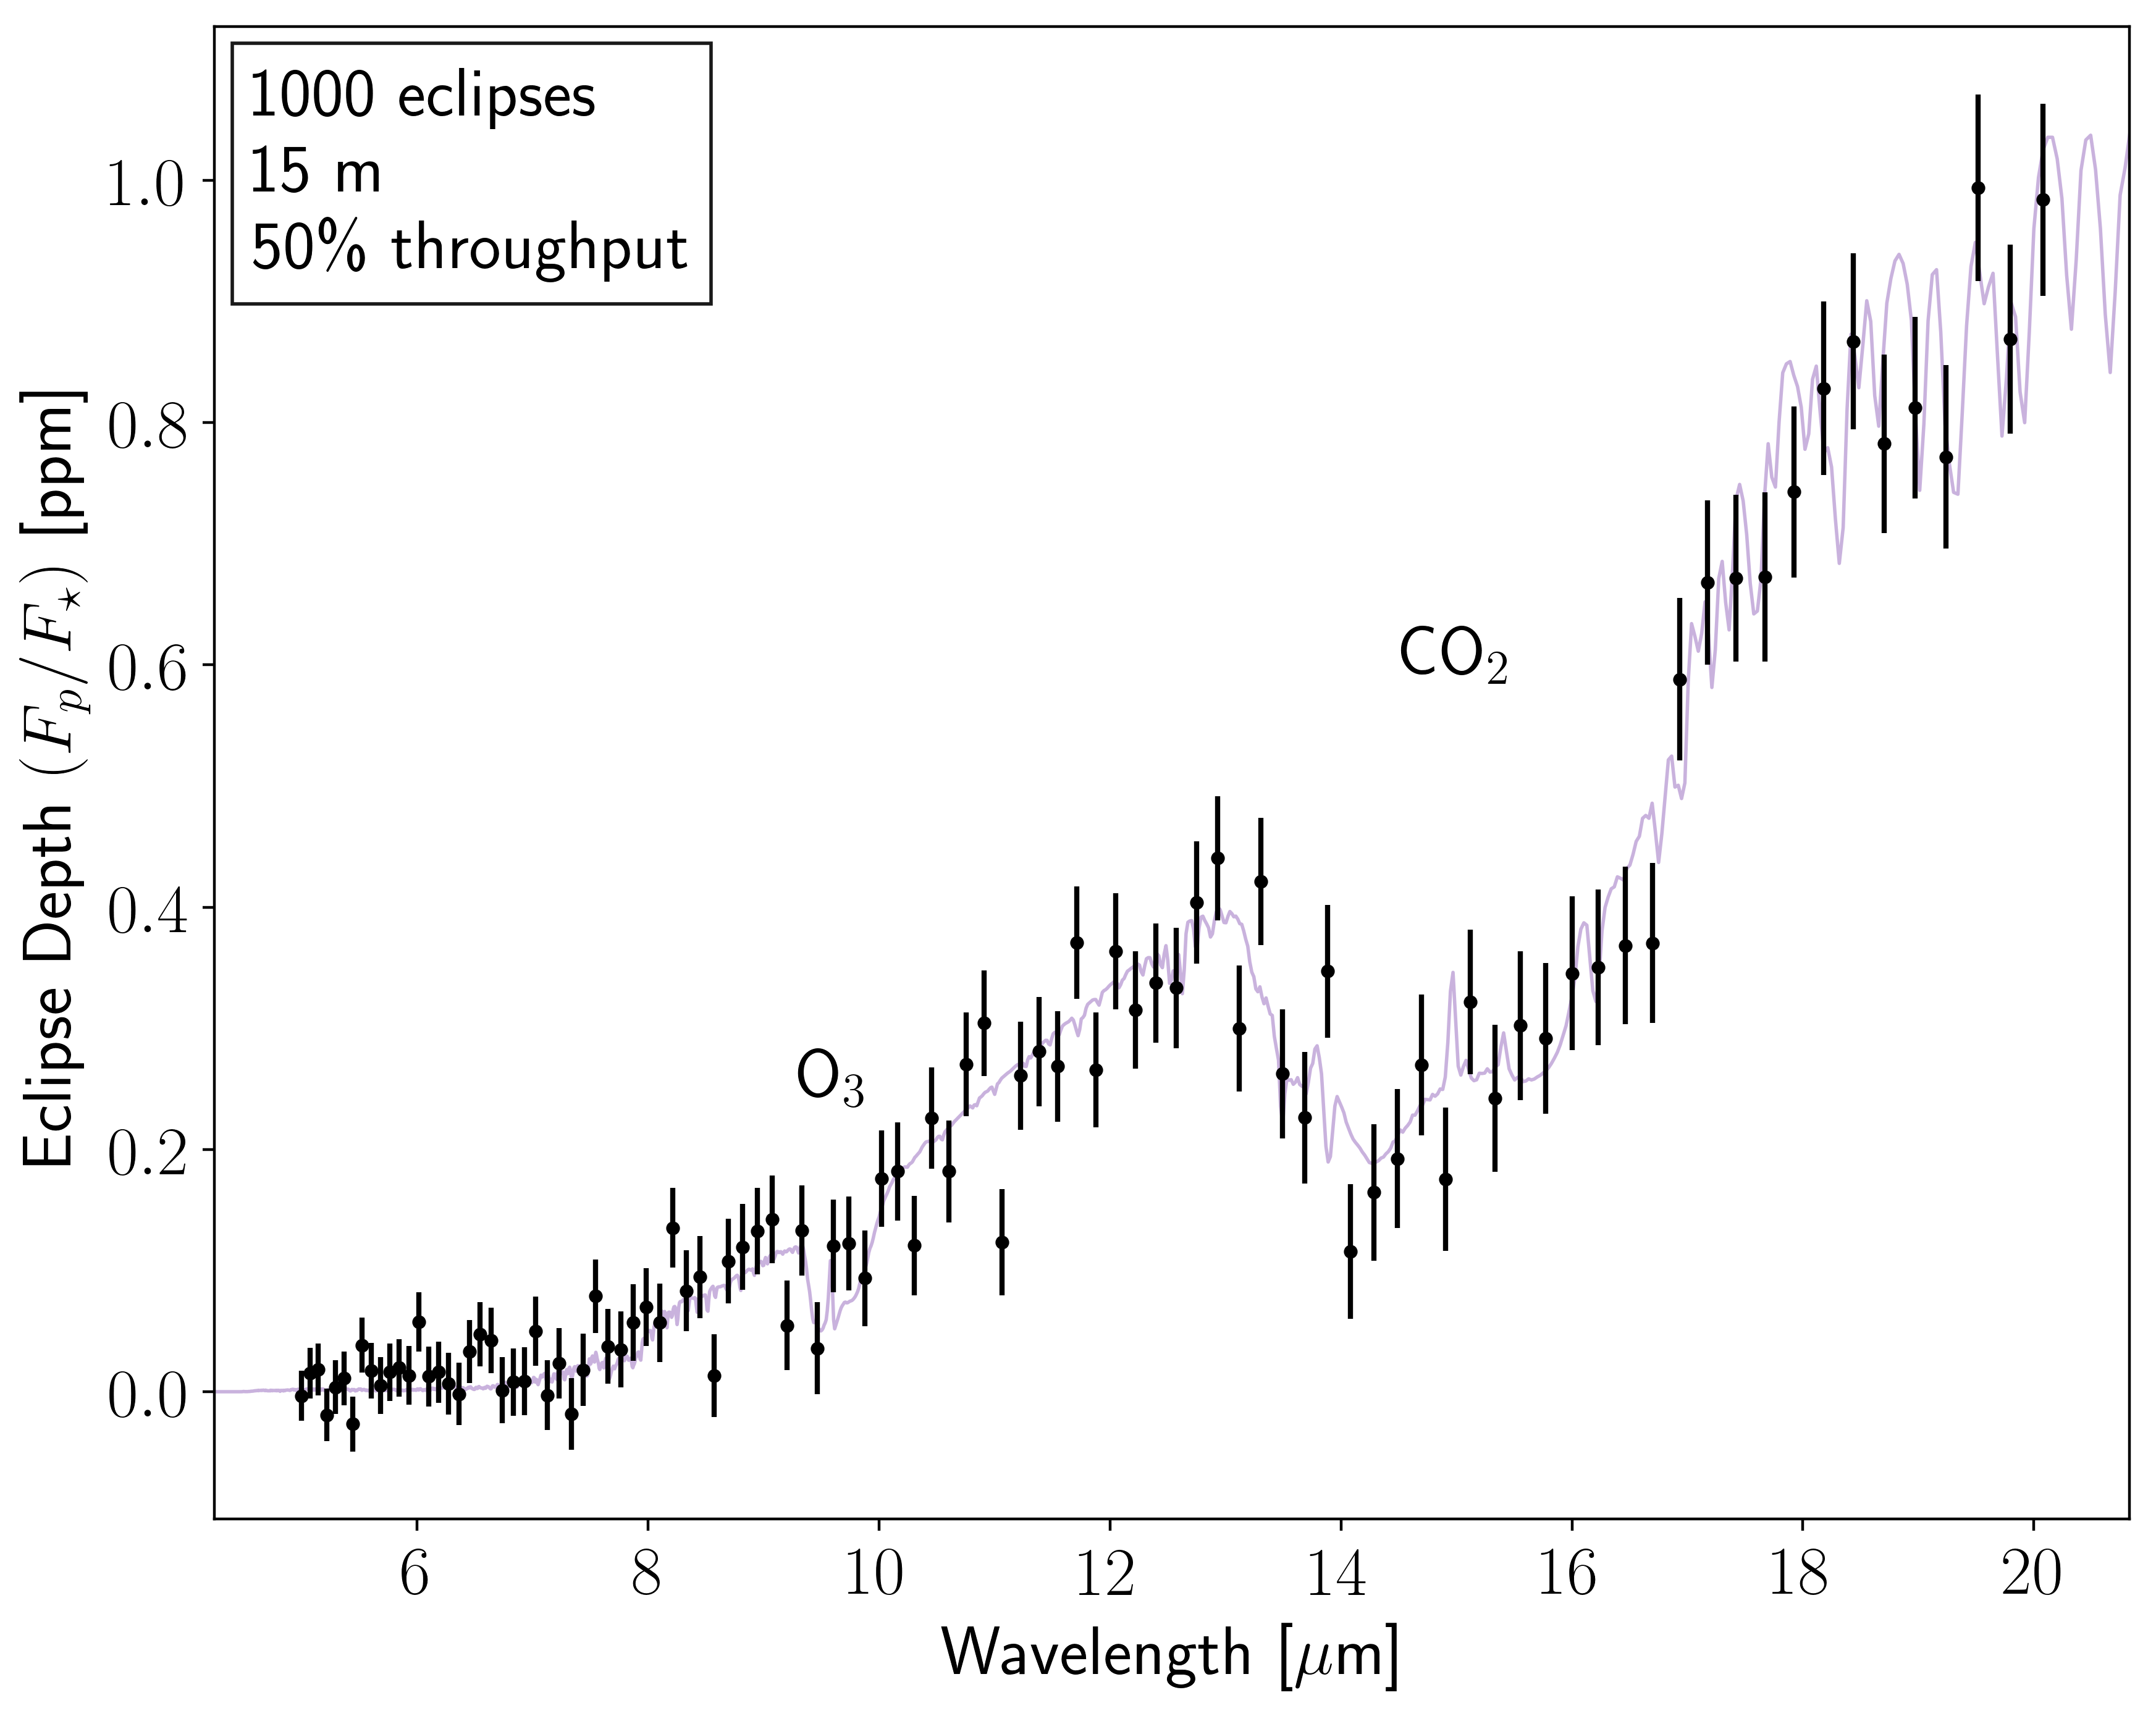

In [10]:
fig, ax = en.plot_spectrum(SNR_threshold=0.0, Nsig=None)
ax.text(15.0, 0.6, r"CO$_2$", va = "center", ha = "center");
ax.text(9.6, 0.25, r"O$_3$", va = "center", ha = "center");

We can three key features. First, we note the general rising trend in the planet-to-star flux contrast with increasing wavelength. This occurs because, even though the Earth is much *much* more faint than the Sun at visible wavelengths, the blackbody intensity is weakly dependent on temperature in the Rayleigh-Jeans limit, so at these longer wavelengths the 288 K Earth and 5700 K Sun have more similar intensities. Second, we see absorption due to CO$_2$ at 15 µm. Finally, we see absorption due to O$_3$ at 9.6 µm. The rise in planet-to-star flux contrast with wavelength increases the relative size of absorption features in the emission spectrum. At first blush this would appear to make detecting molecules easier at longer wavelengths, however, photons are few and far between at these wavelengths and thermal noise tends to increase with wavelength, making the optimal wavelengths for molecular detection more complicated and telescope-dependent.  

Let's take a look that the signal-to-noise as a function of wavelength. 

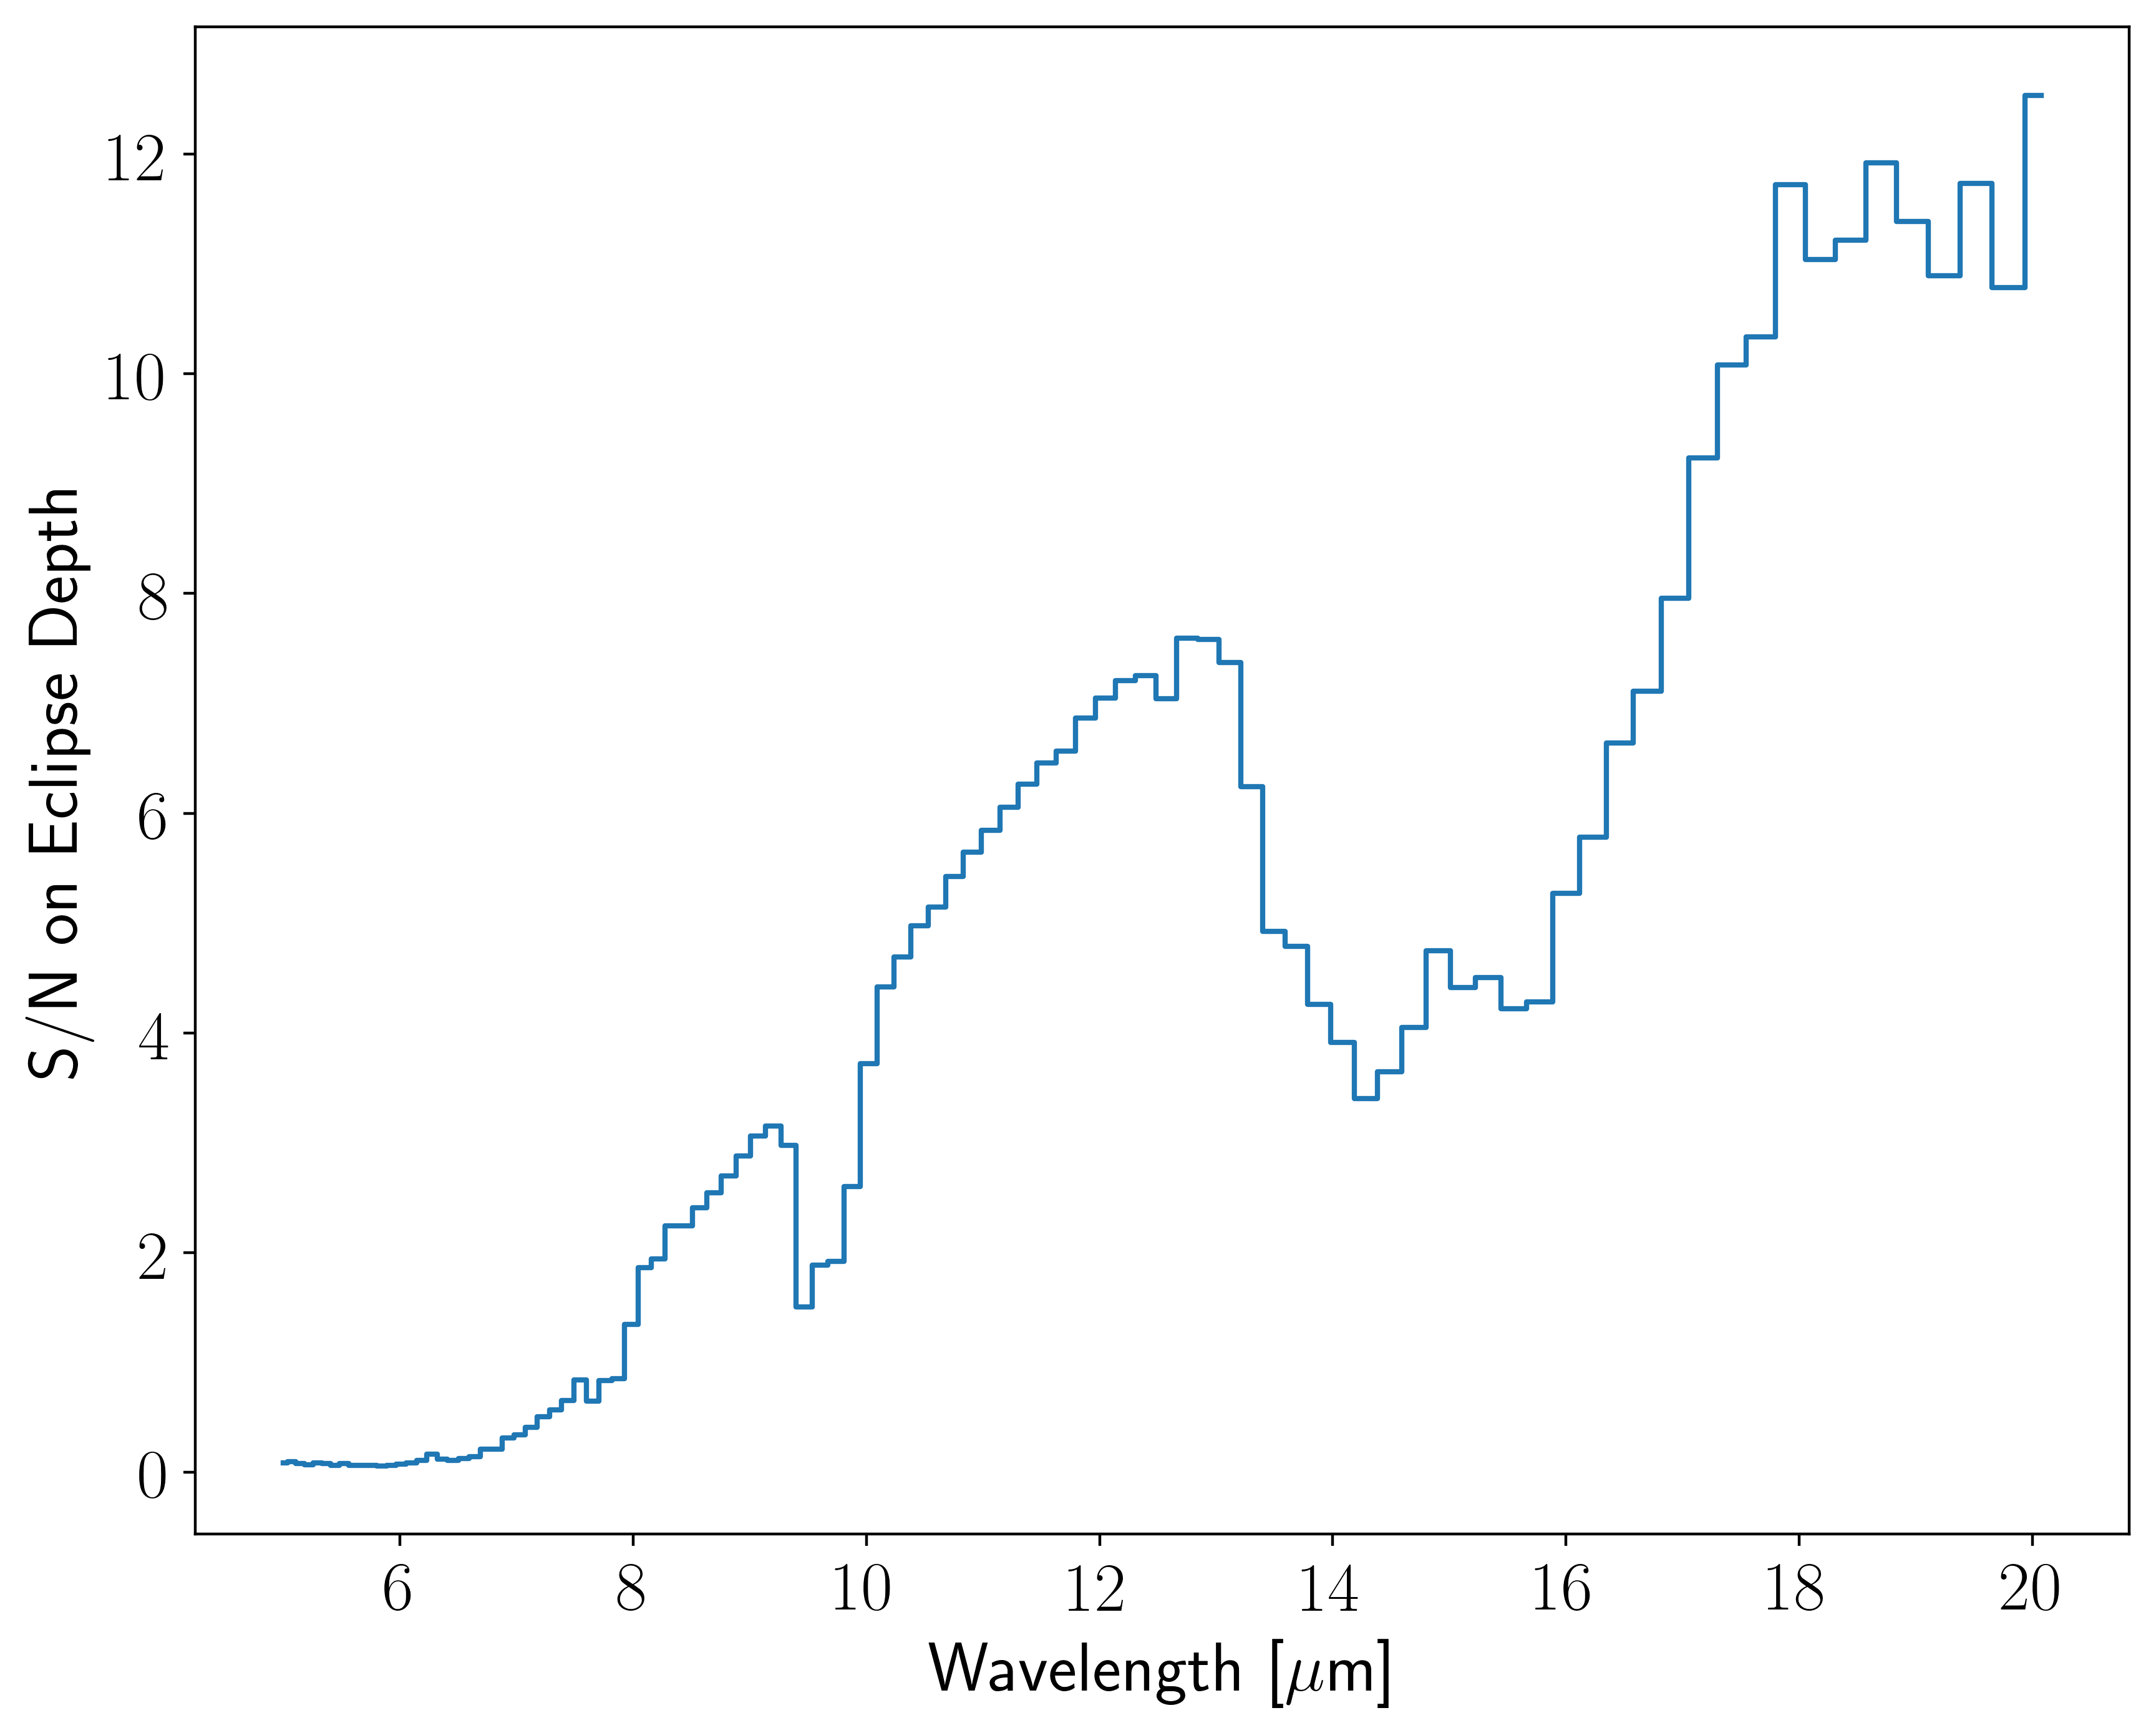

In [11]:
fig, ax = en.plot_SNRn()

Sometimes it's nice to see the number of eclipses that must be observed to get a given S/N in each spectral element. Let's take a look at these devastating numbers for the Earth around the Sun. 

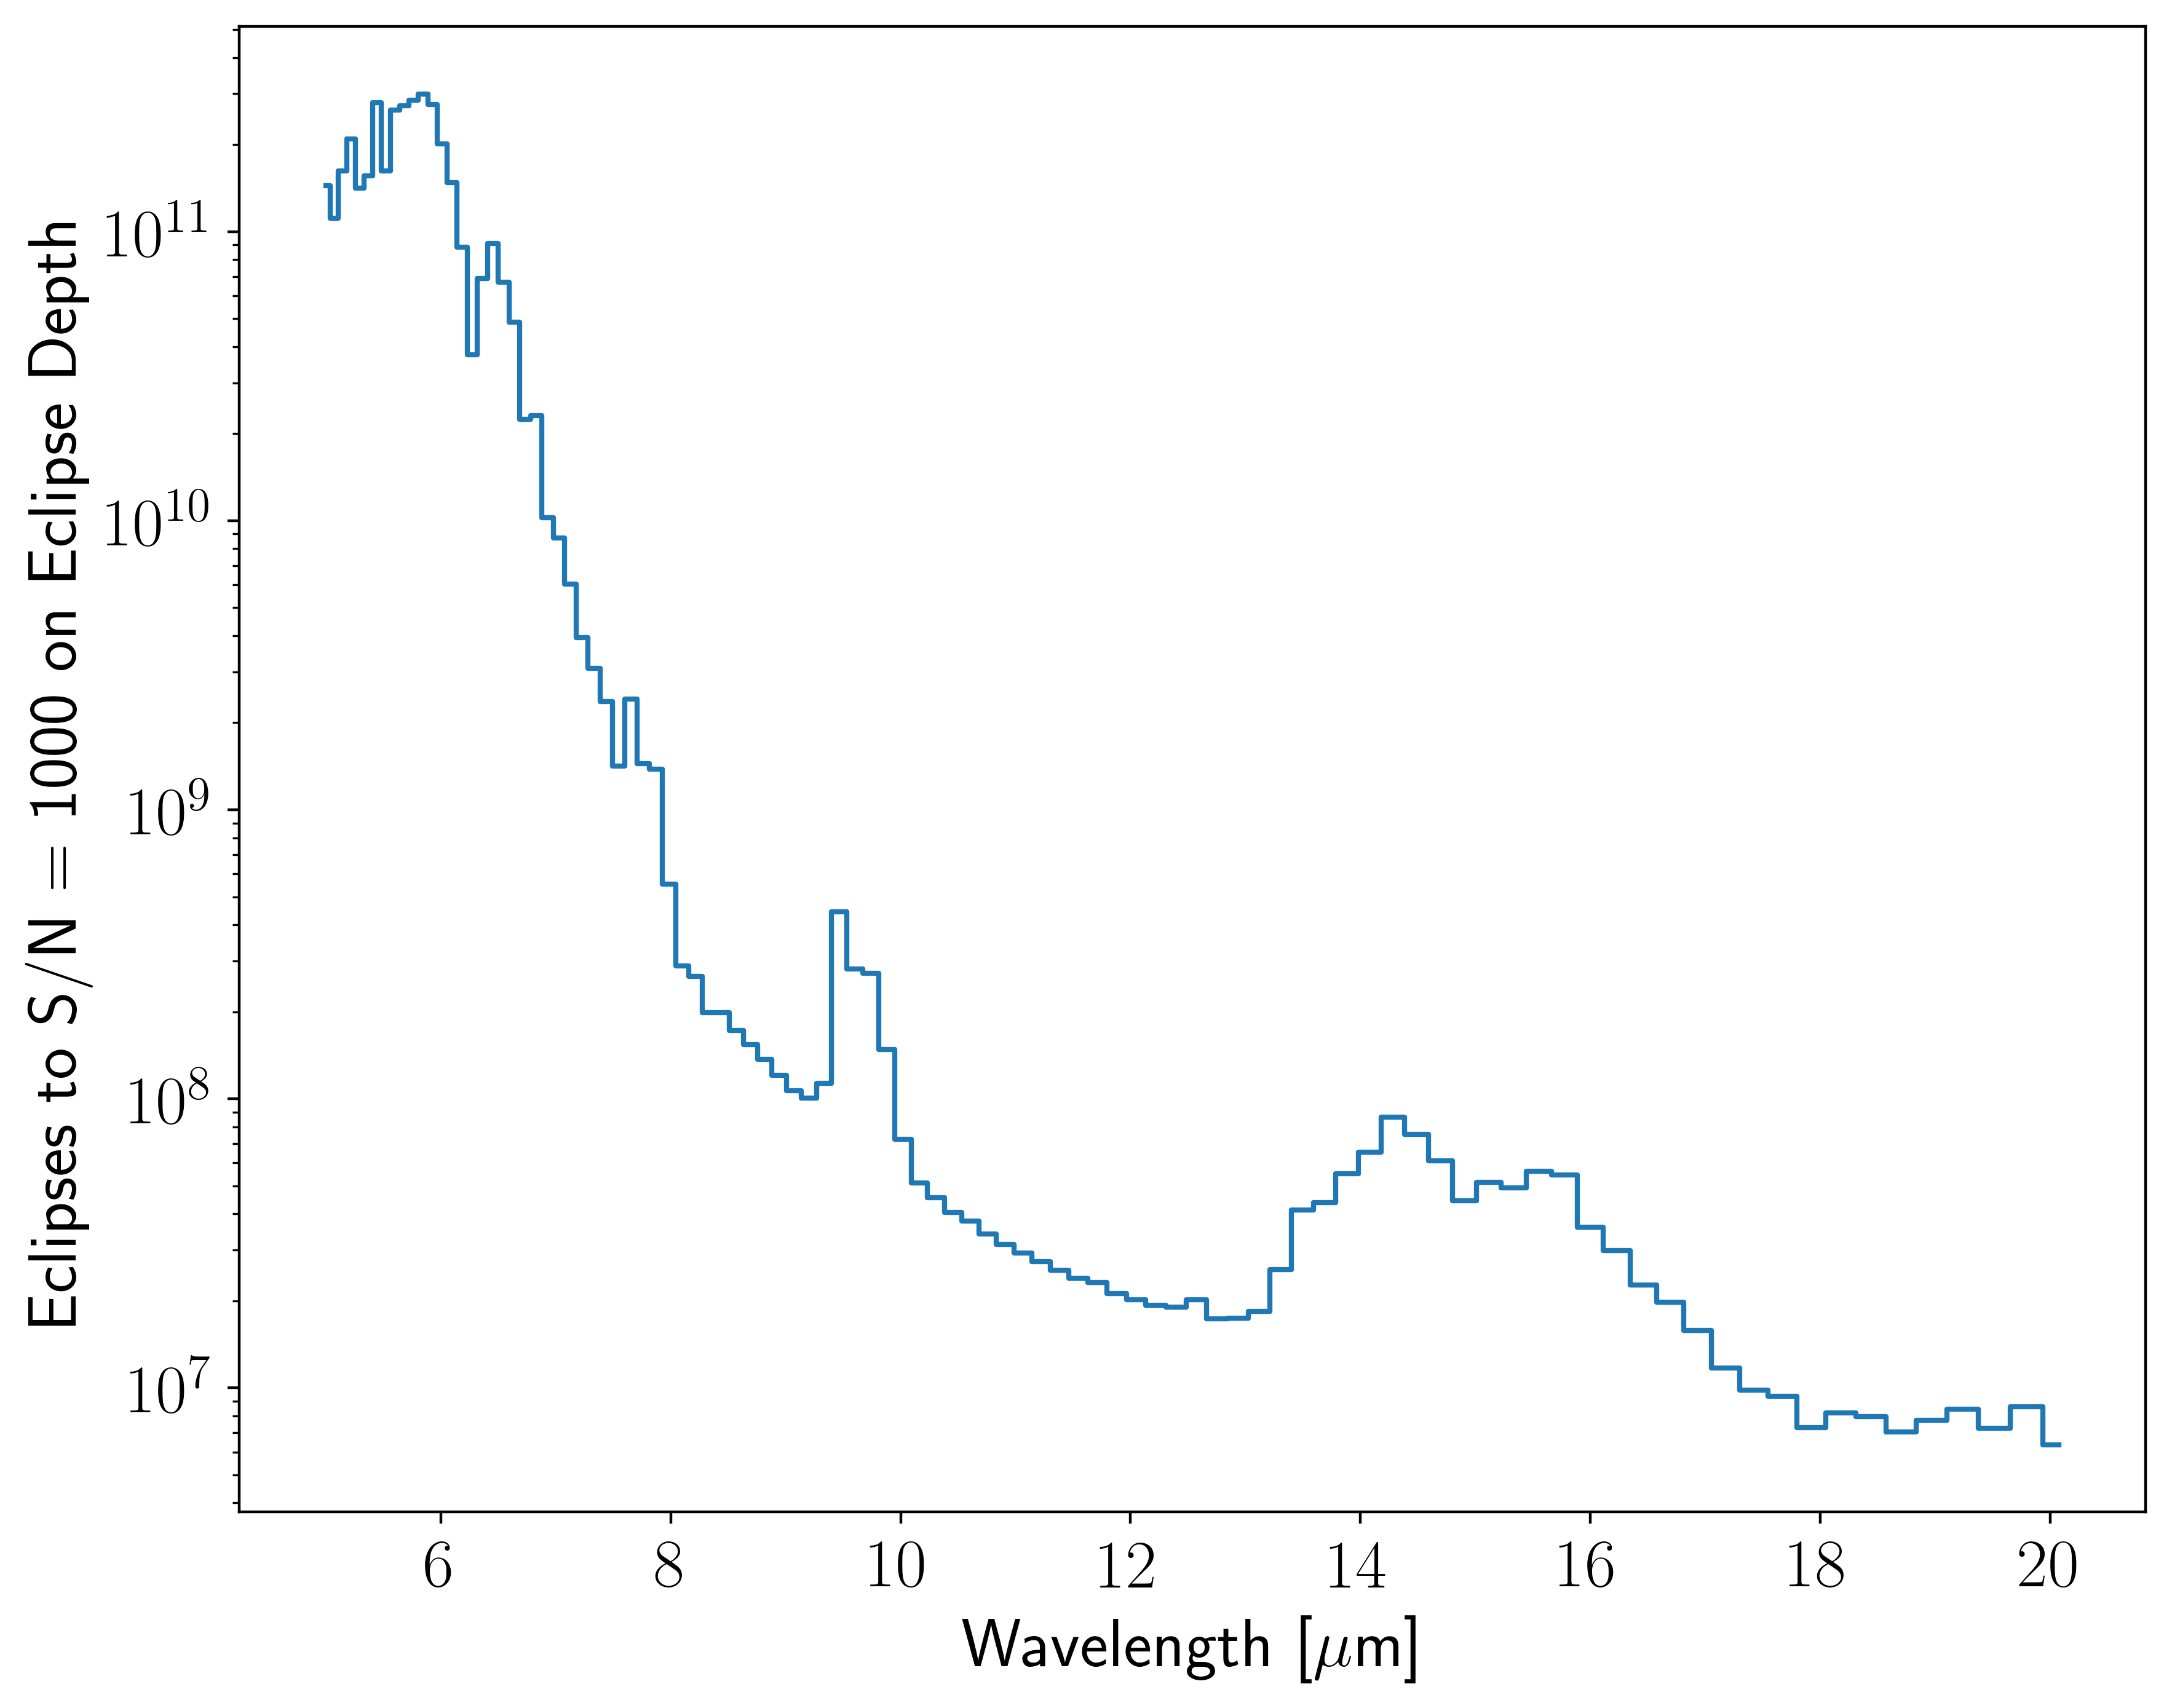

In [12]:
fig, ax = en.plot_ntran_to_wantsnr()

So this is really just too ridiculous. The ultimate reason for that can be gleaned from the last plot in this series, where we take a look at the photon count rates incident upon the detector from various noise sources compared to our signal.  

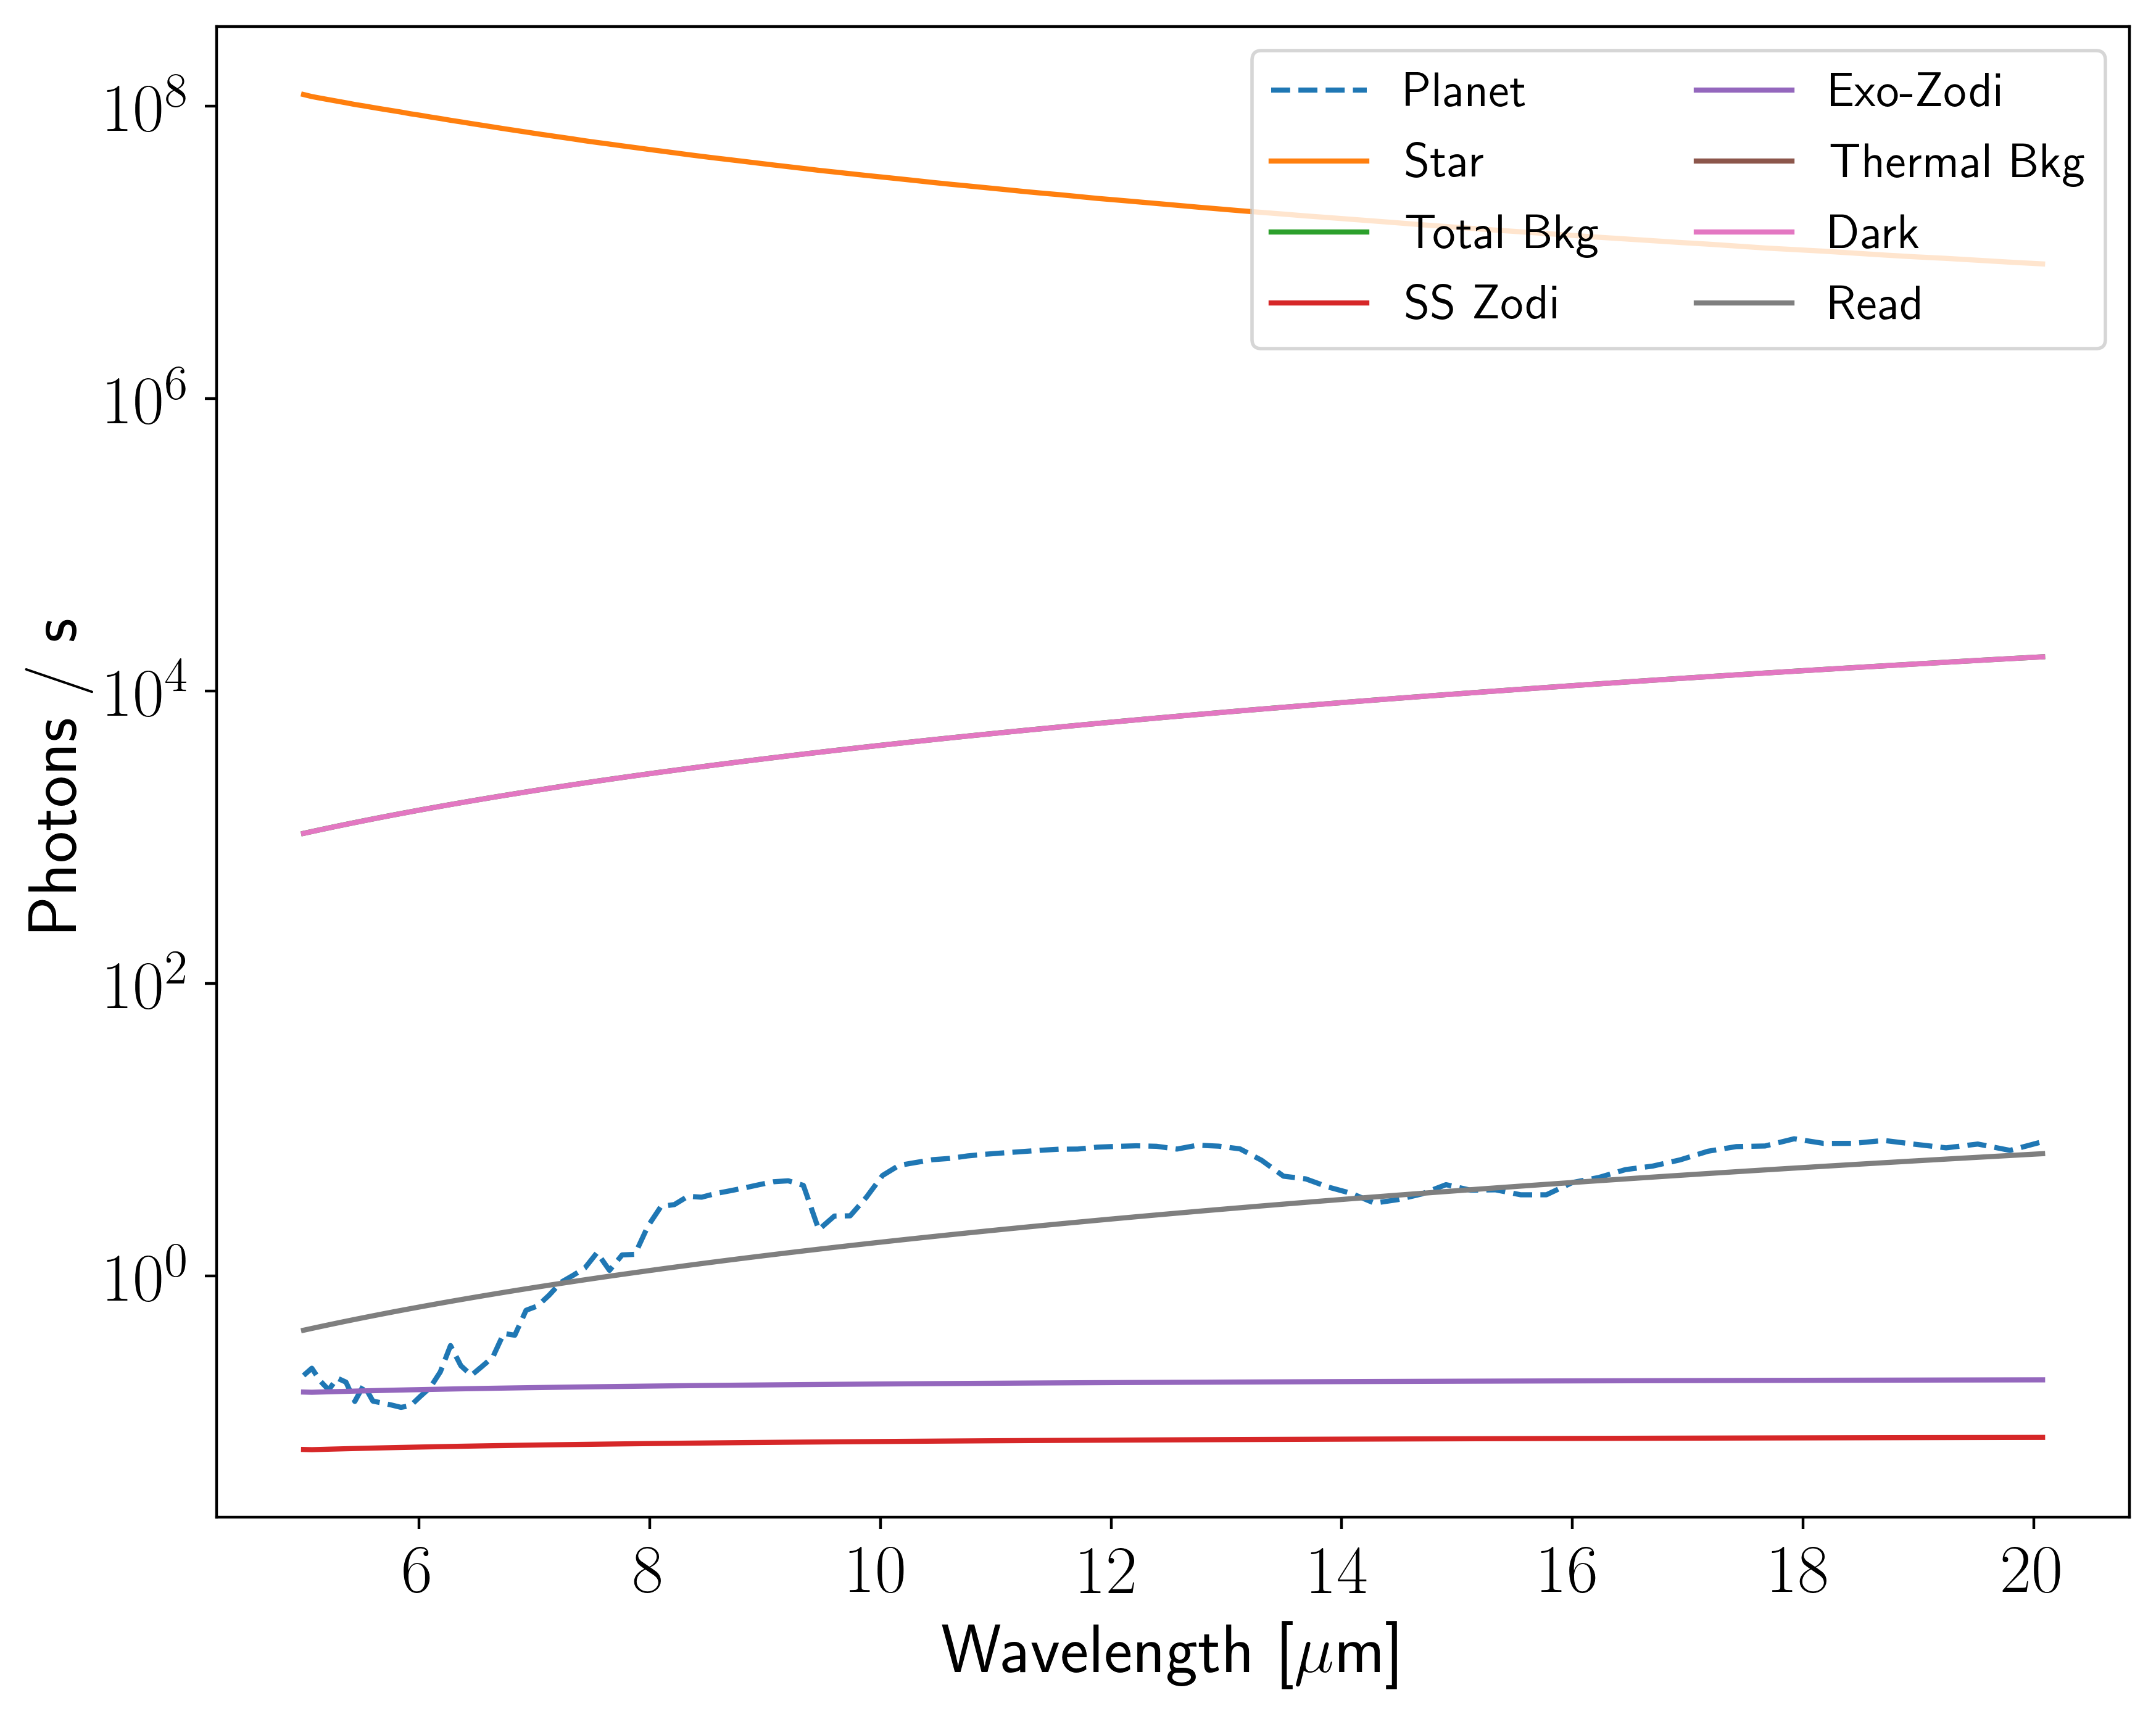

In [13]:
fig, ax = en.plot_count_rates()

We see that it's all about the star. The themral emission from the Sun outshines the thermal emission from the Earth by ~6 orders of magnitude at 20 µm, and there aren't enough photons to overcome this contrast in any reasonable amount of time. 

## Simulating a *featureless* spectrum  

We've heard a lot about featureless *transmission* spectra. This can occur due to high altitude aerosols or heavy and/or cool atmospheres. But what does a featureless emission spectrum look like?   

In short, it looks like a ratio of blackbody fluxes:  

$$ \frac{F_p}{F_{\star}} \approx \frac{B_p}{B_{\star}} \left ( \frac{R_p}{R_{\star}} \right )^2 $$  

But let's see how we can investigate this with the `coronagraph` model.  

We're going to use the same planet and star as above, but now let's set a temperature for the planet:

In [14]:
planet.Tplan = 288

Now we can create a new `EclipseNoise` object for our featureless spectrum and calculate the photon count rates. 

In [15]:
enf = cg.EclipseNoise(tdur = tdur,
                      telescope = telescope,
                      planet = planet,
                      star = star,
                      ntran = ntran,
                      nout = nout)

enf.run_count_rates(lam)

Let's plot our new featureless spectrum and compare it with Earth's emission spectrum.

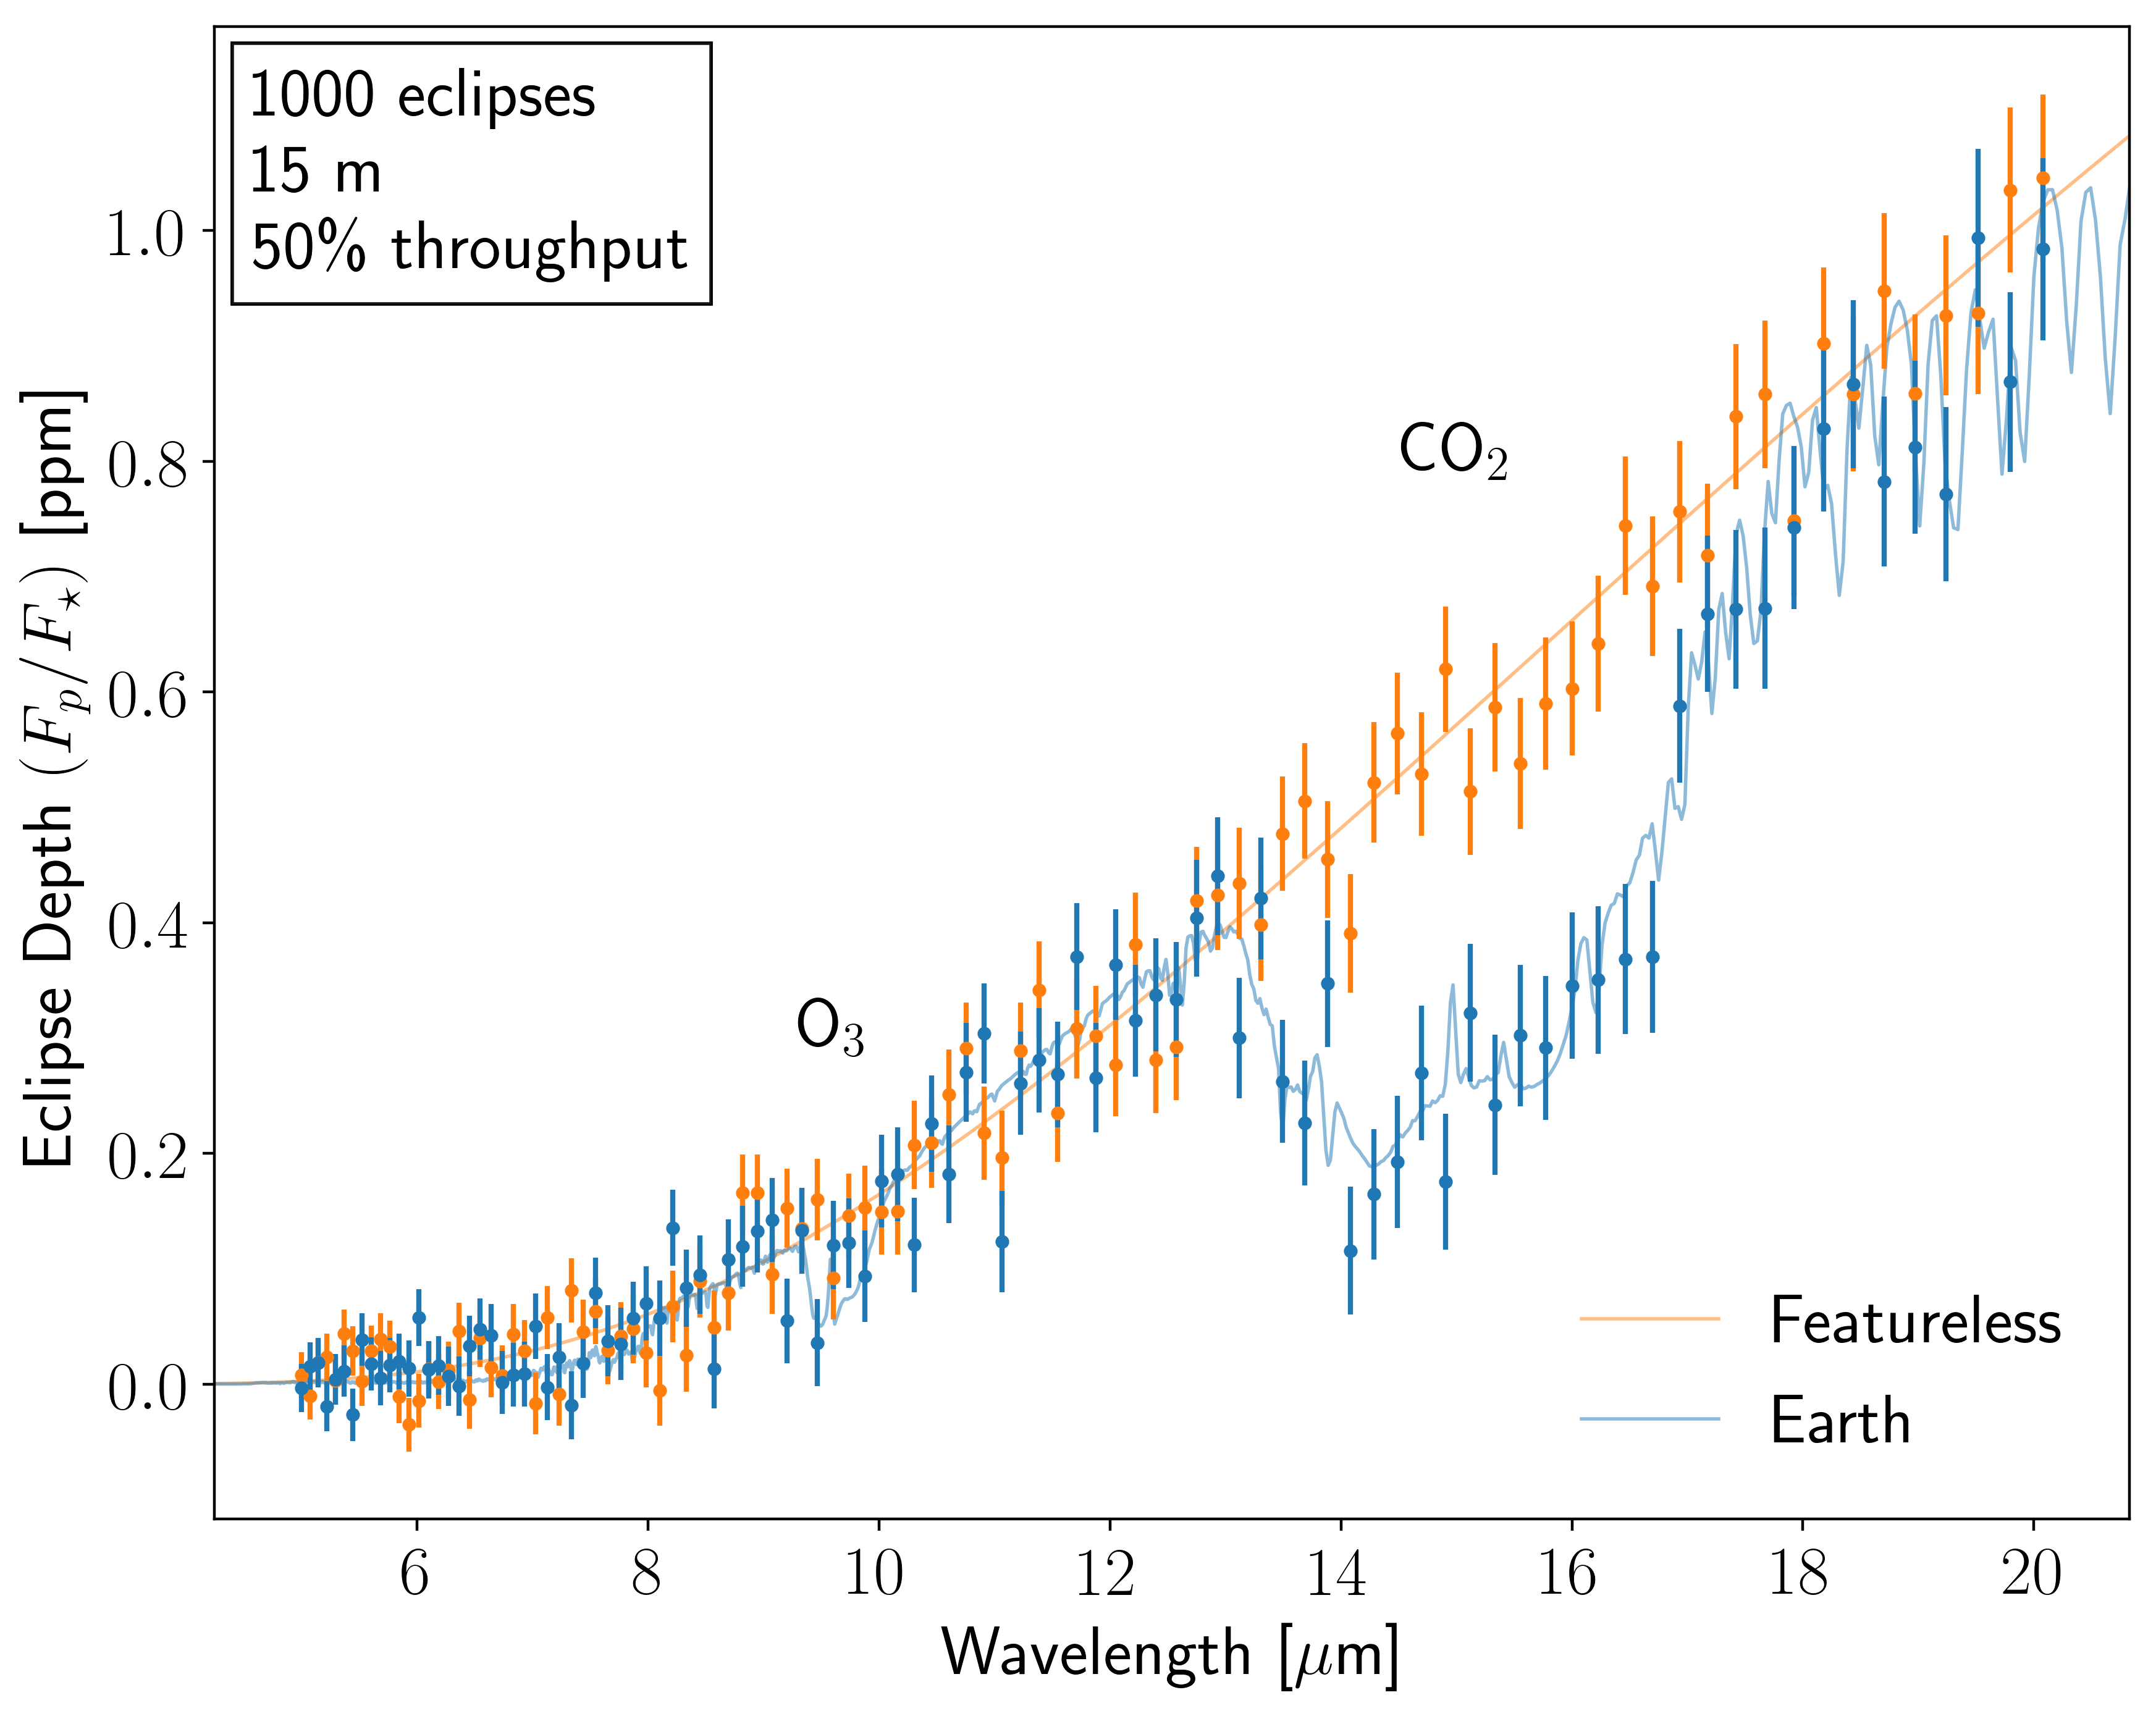

In [16]:
# Plot Spectrum
fig, ax = enf.plot_spectrum(SNR_threshold=0.0, Nsig=None, 
                            err_kws={'fmt': '.', 'c': 'C1', 'alpha': 1}, 
                            plot_kws={'lw': 1.0, 'c': 'C1', 'alpha': 0.5, 'label' : 'Featureless'})

# Add Earth's emission spectrum to the axis
en.plot_spectrum(SNR_threshold=0.0, Nsig=None, ax0=ax, 
                 err_kws={'fmt': '.', 'c': 'C0', 'alpha': 1}, 
                 plot_kws={'lw': 1.0, 'c': 'C0', 'alpha': 0.5, 'label' : 'Earth'})

# Add legend
leg = ax.legend(loc = 4)
leg.get_frame().set_alpha(0.0)

# Annotate molecules
ax.text(15.0, 0.8, r"CO$_2$", va = "center", ha = "center");
ax.text(9.6, 0.3, r"O$_3$", va = "center", ha = "center");

## What about M-dwarfs?  

So far we have looked at the extremely unrealistic scenario of observing Earth in secondary eclipse around the Sun. Now let's shift our focus to the late M-dwarf TRAPPIST-1 to see what the Earth would look like in secondary eclipse around this small, cool, dim star.  

We'll start by modifying the effective temperature `Teff` and the radius `Rs` of the `star`:

In [17]:
star.Teff = 2510
star.Rs = 0.117

Let's instantiate an `EclipseNoise` object but now we'll use the transit duration of TRAPPIST-1e and only observe 25 secondary eclipses. 

In [18]:
enm = cg.EclipseNoise(tdur = 3432.0,
                      telescope = telescope,
                      planet = planet,
                      star = star,
                      ntran = 25.0,
                      nout = nout)

enm.run_count_rates(lam, fplan)

Here's the emission spectrum:

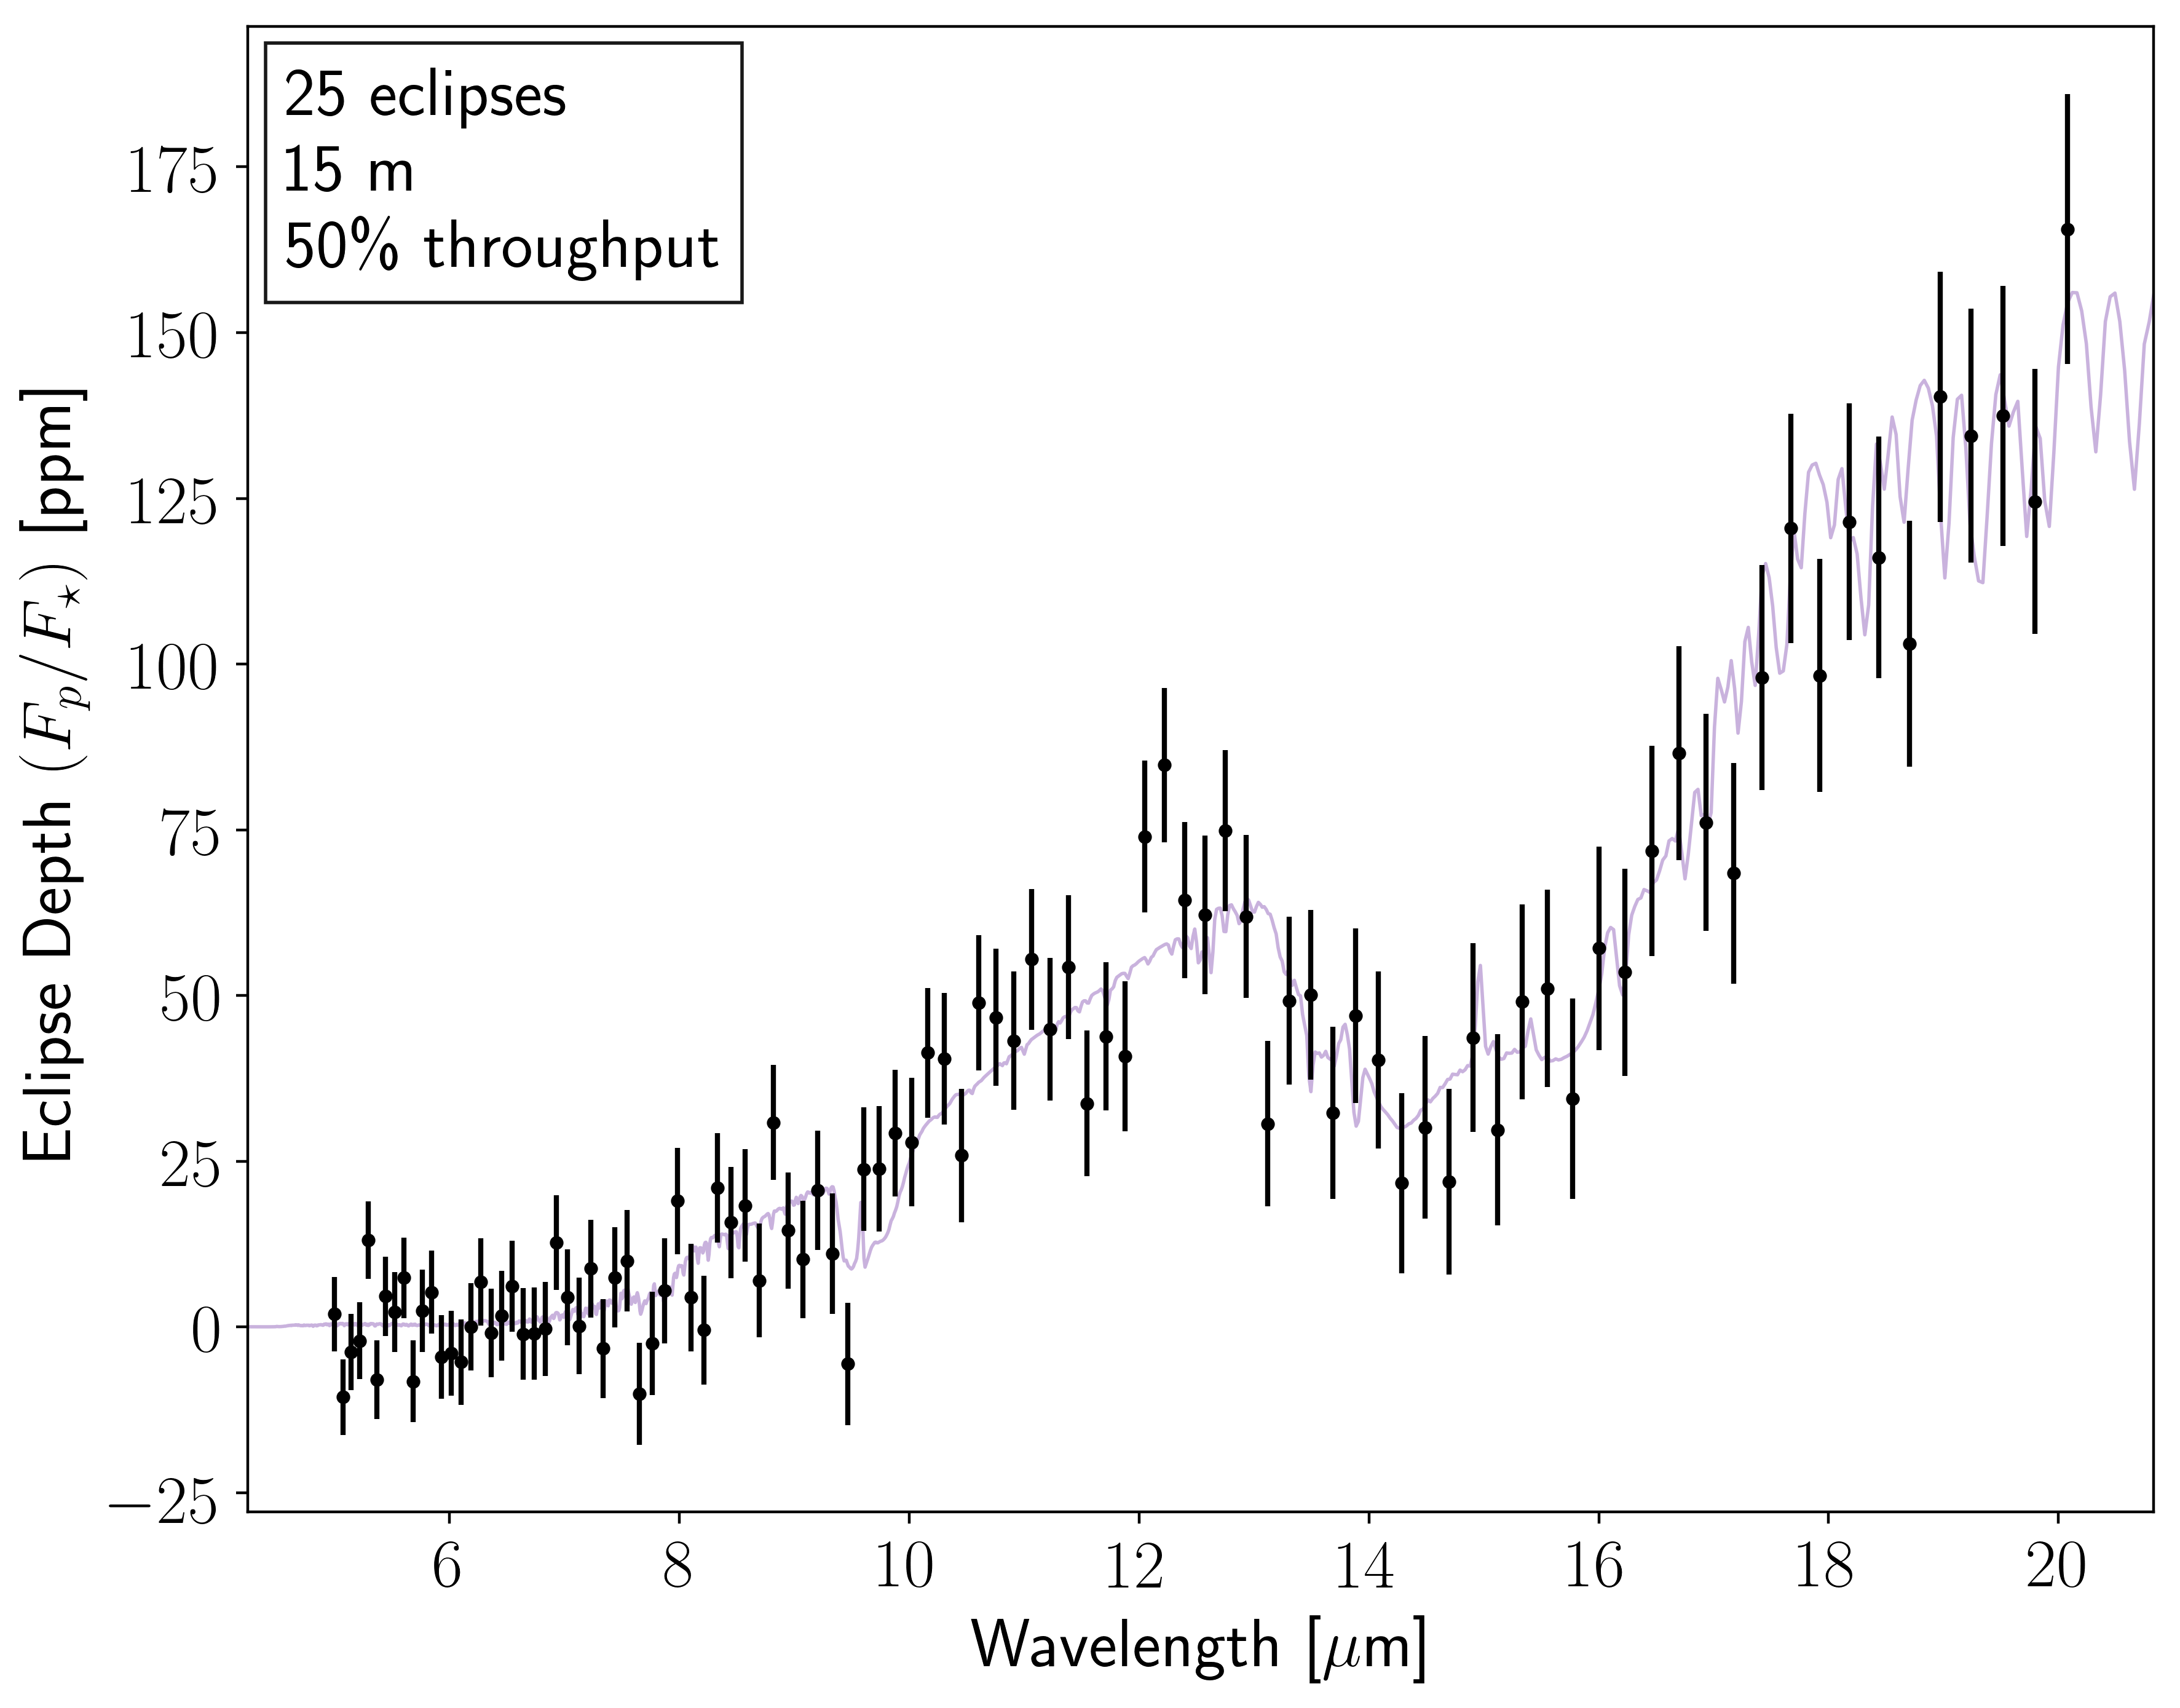

In [19]:
fig, ax = enm.plot_spectrum(SNR_threshold=0.0, Nsig=None)

Now we're in business!

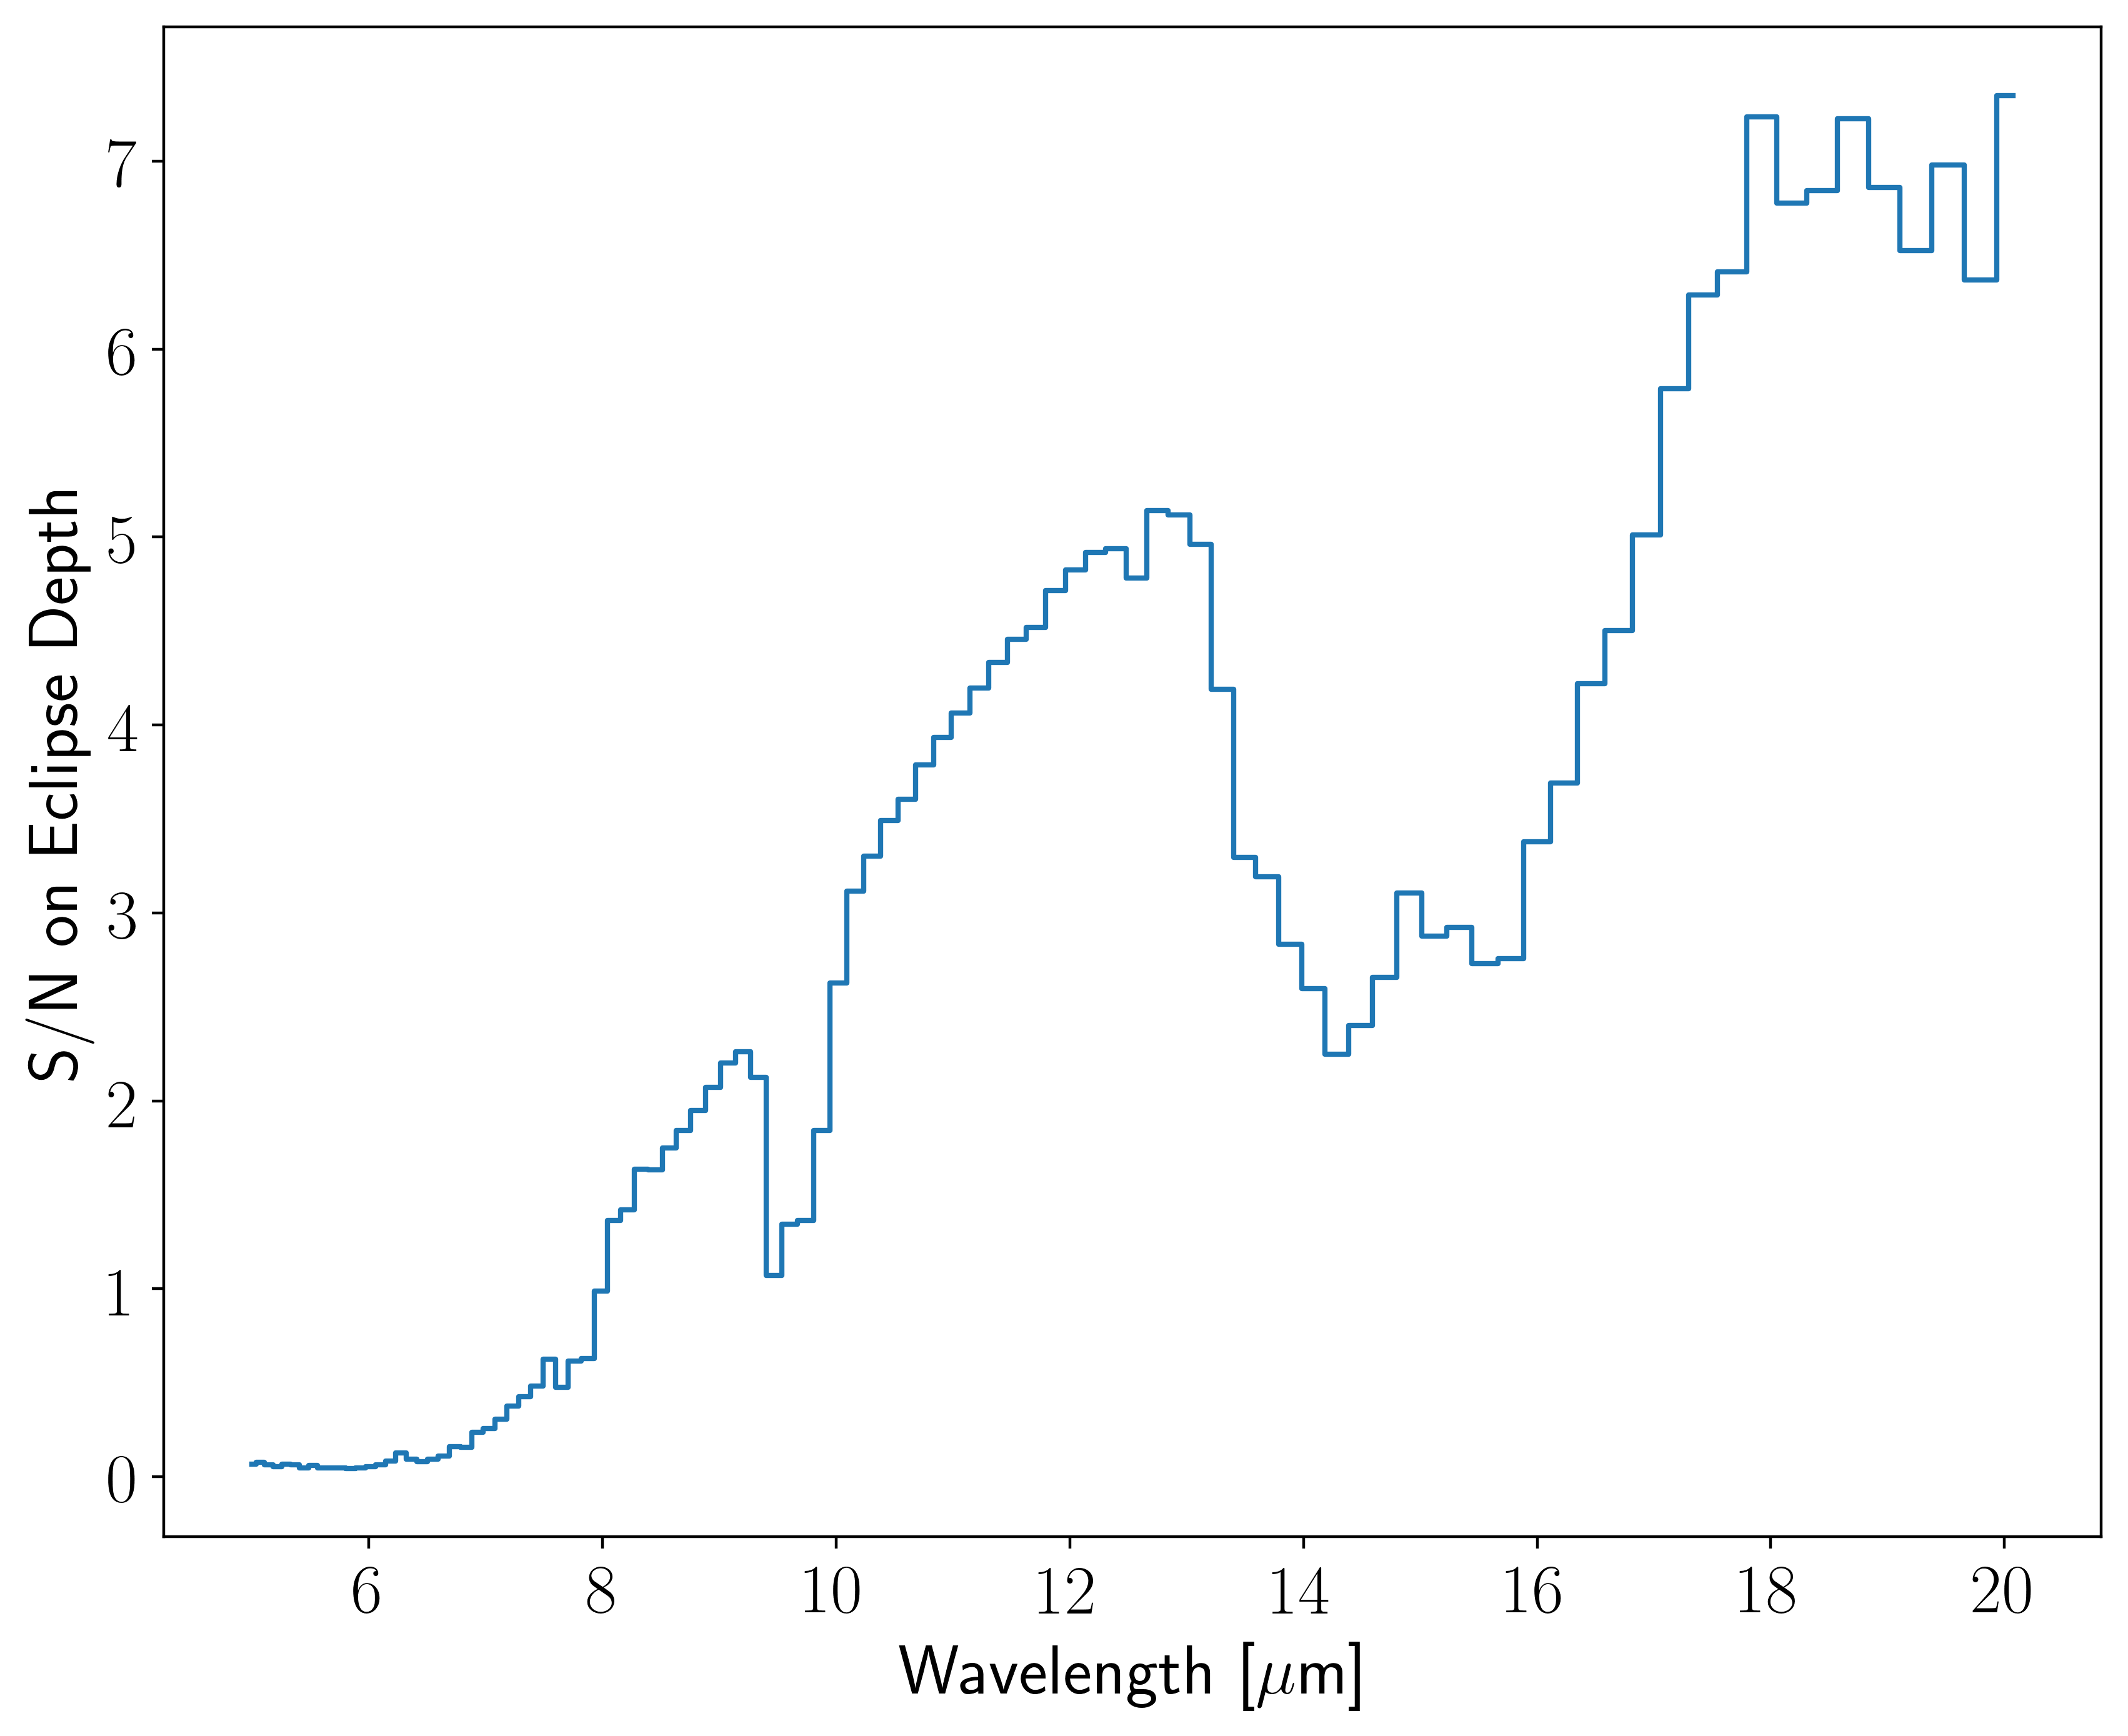

In [20]:
fig, ax = enm.plot_SNRn()

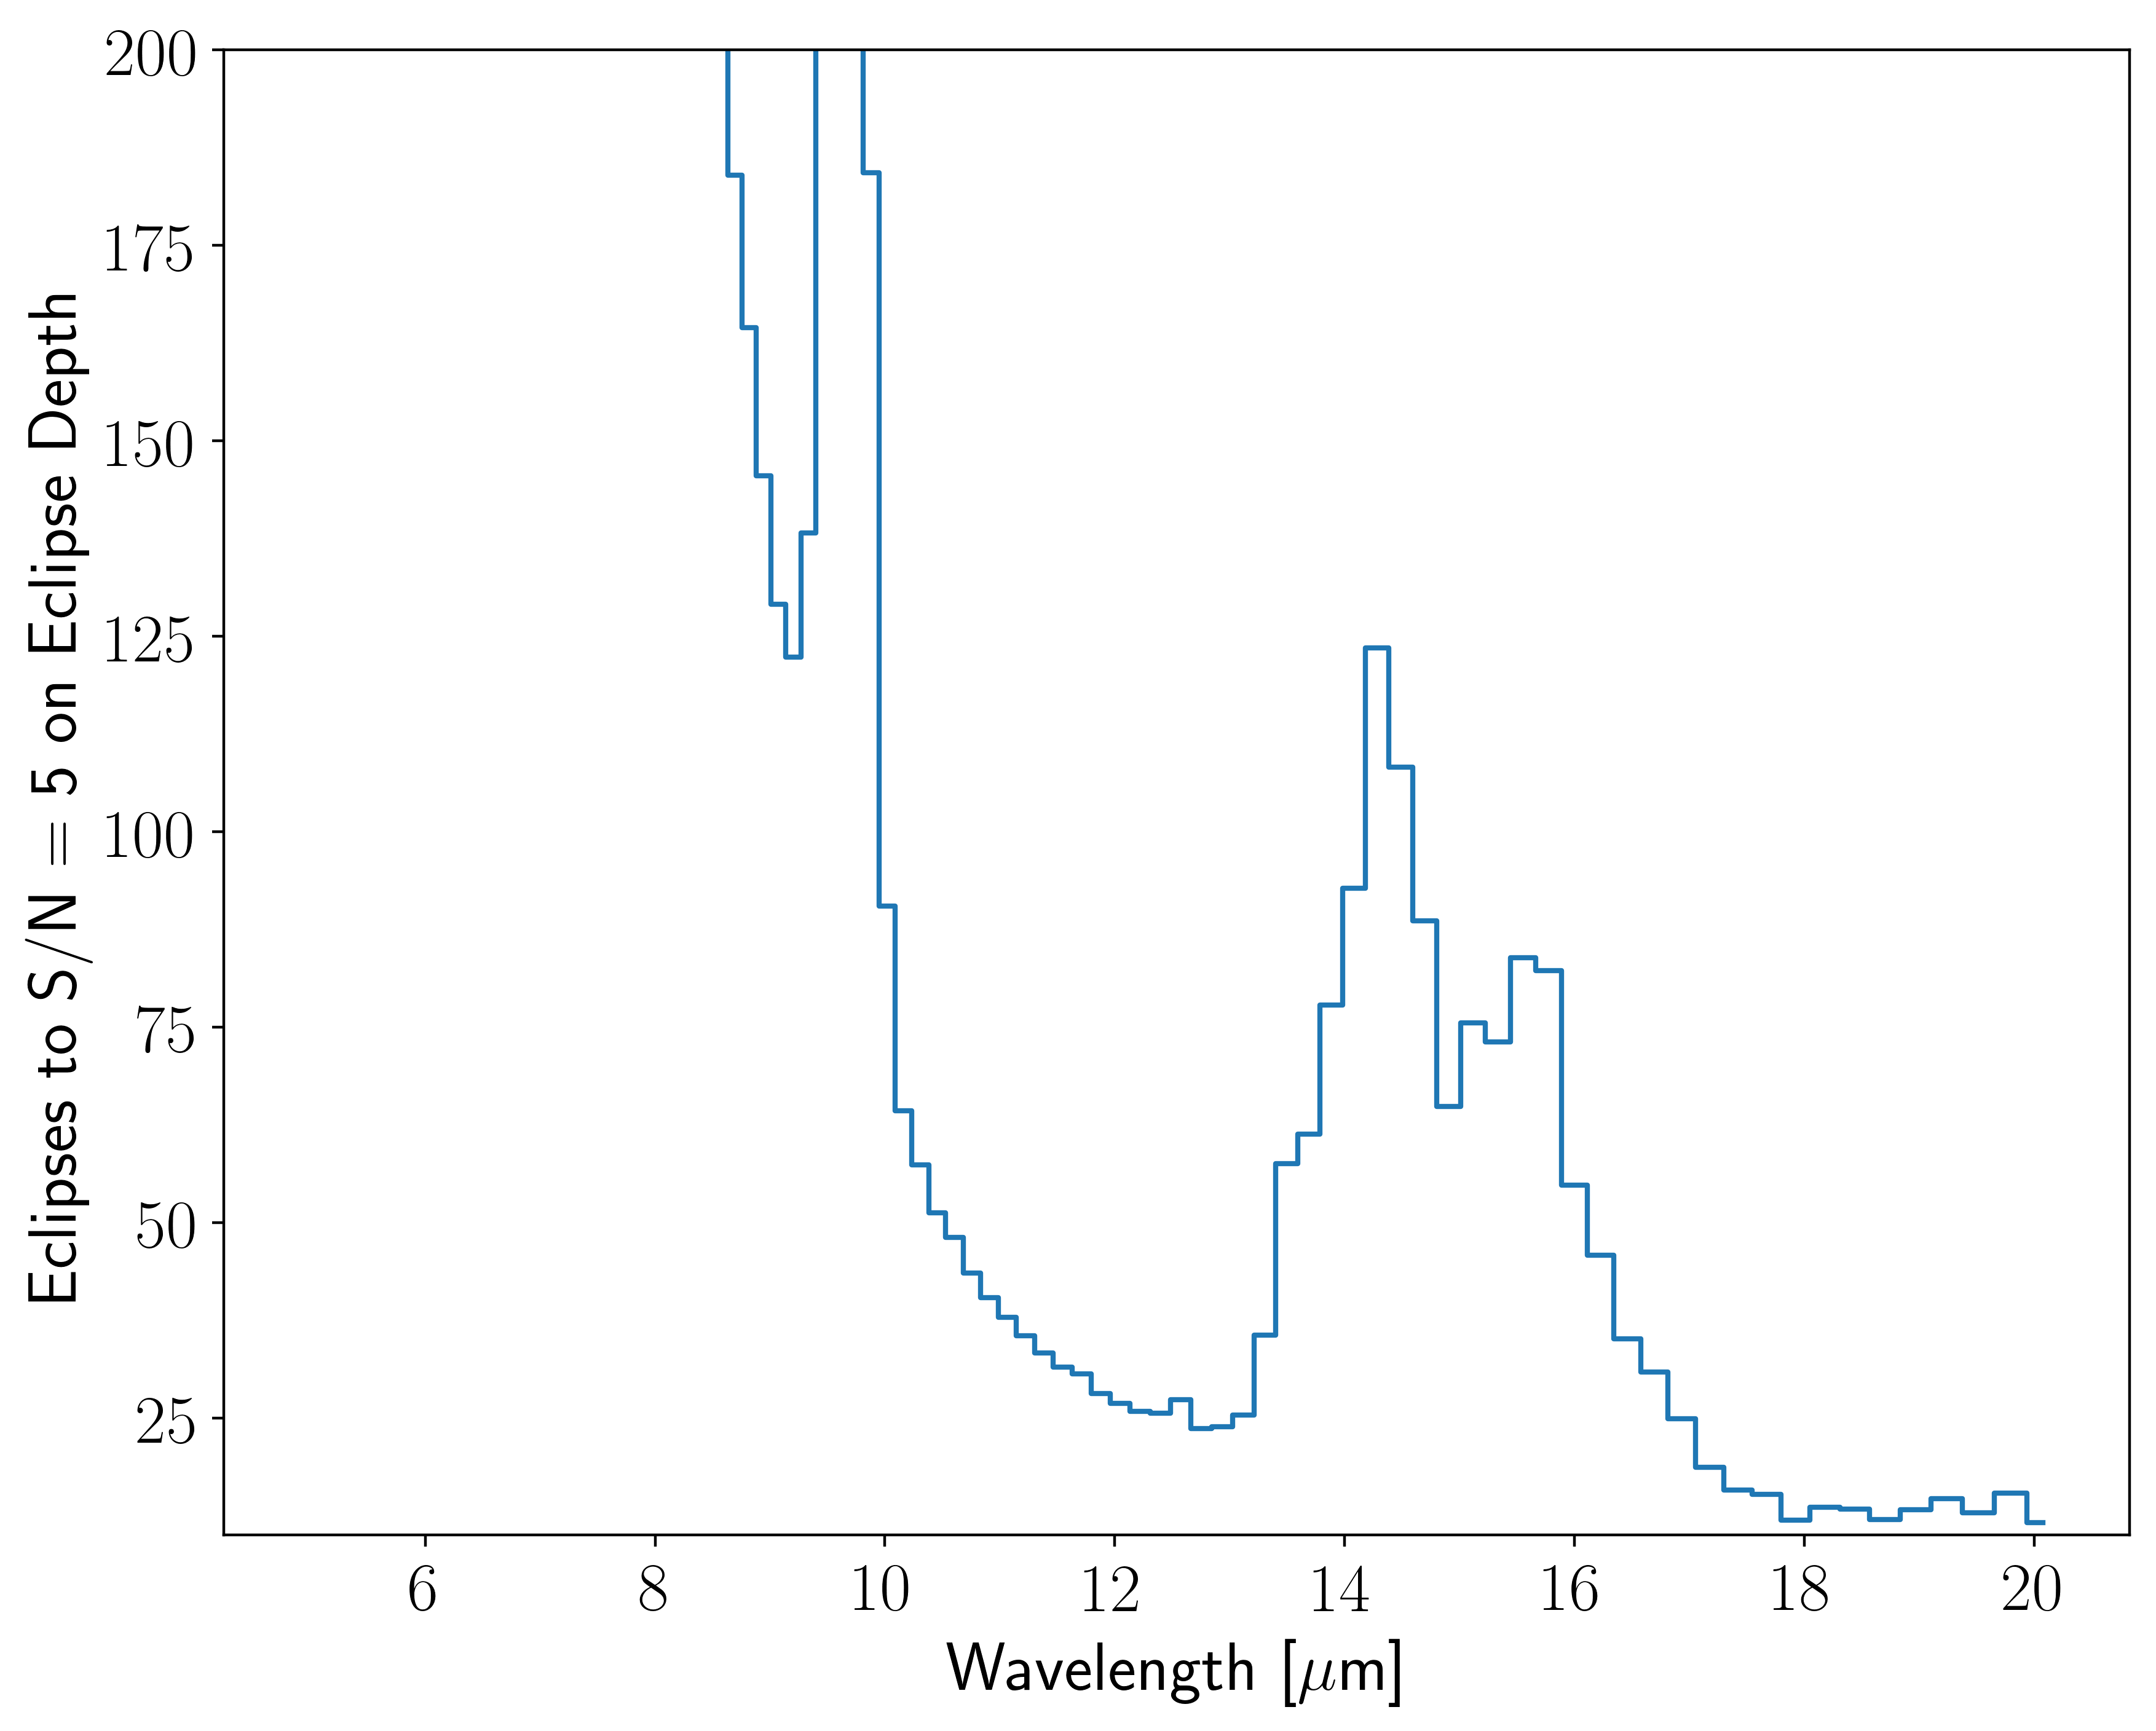

In [21]:
enm.recalc_wantsnr(wantsnr = 5.0)
fig, ax = enm.plot_ntran_to_wantsnr()
ax.set_yscale("linear")
ax.set_ylim(10,200);

Note that a S/N of 5 on each spectral element says nothing of the ability to detect molecules. The 15 µm CO$_2$ band as seen in the spectrum above is detected at greater than S/N=5 even though the S/N<5 *in each element* within the absorption band.   

Finally, let's look at the photon count rates.

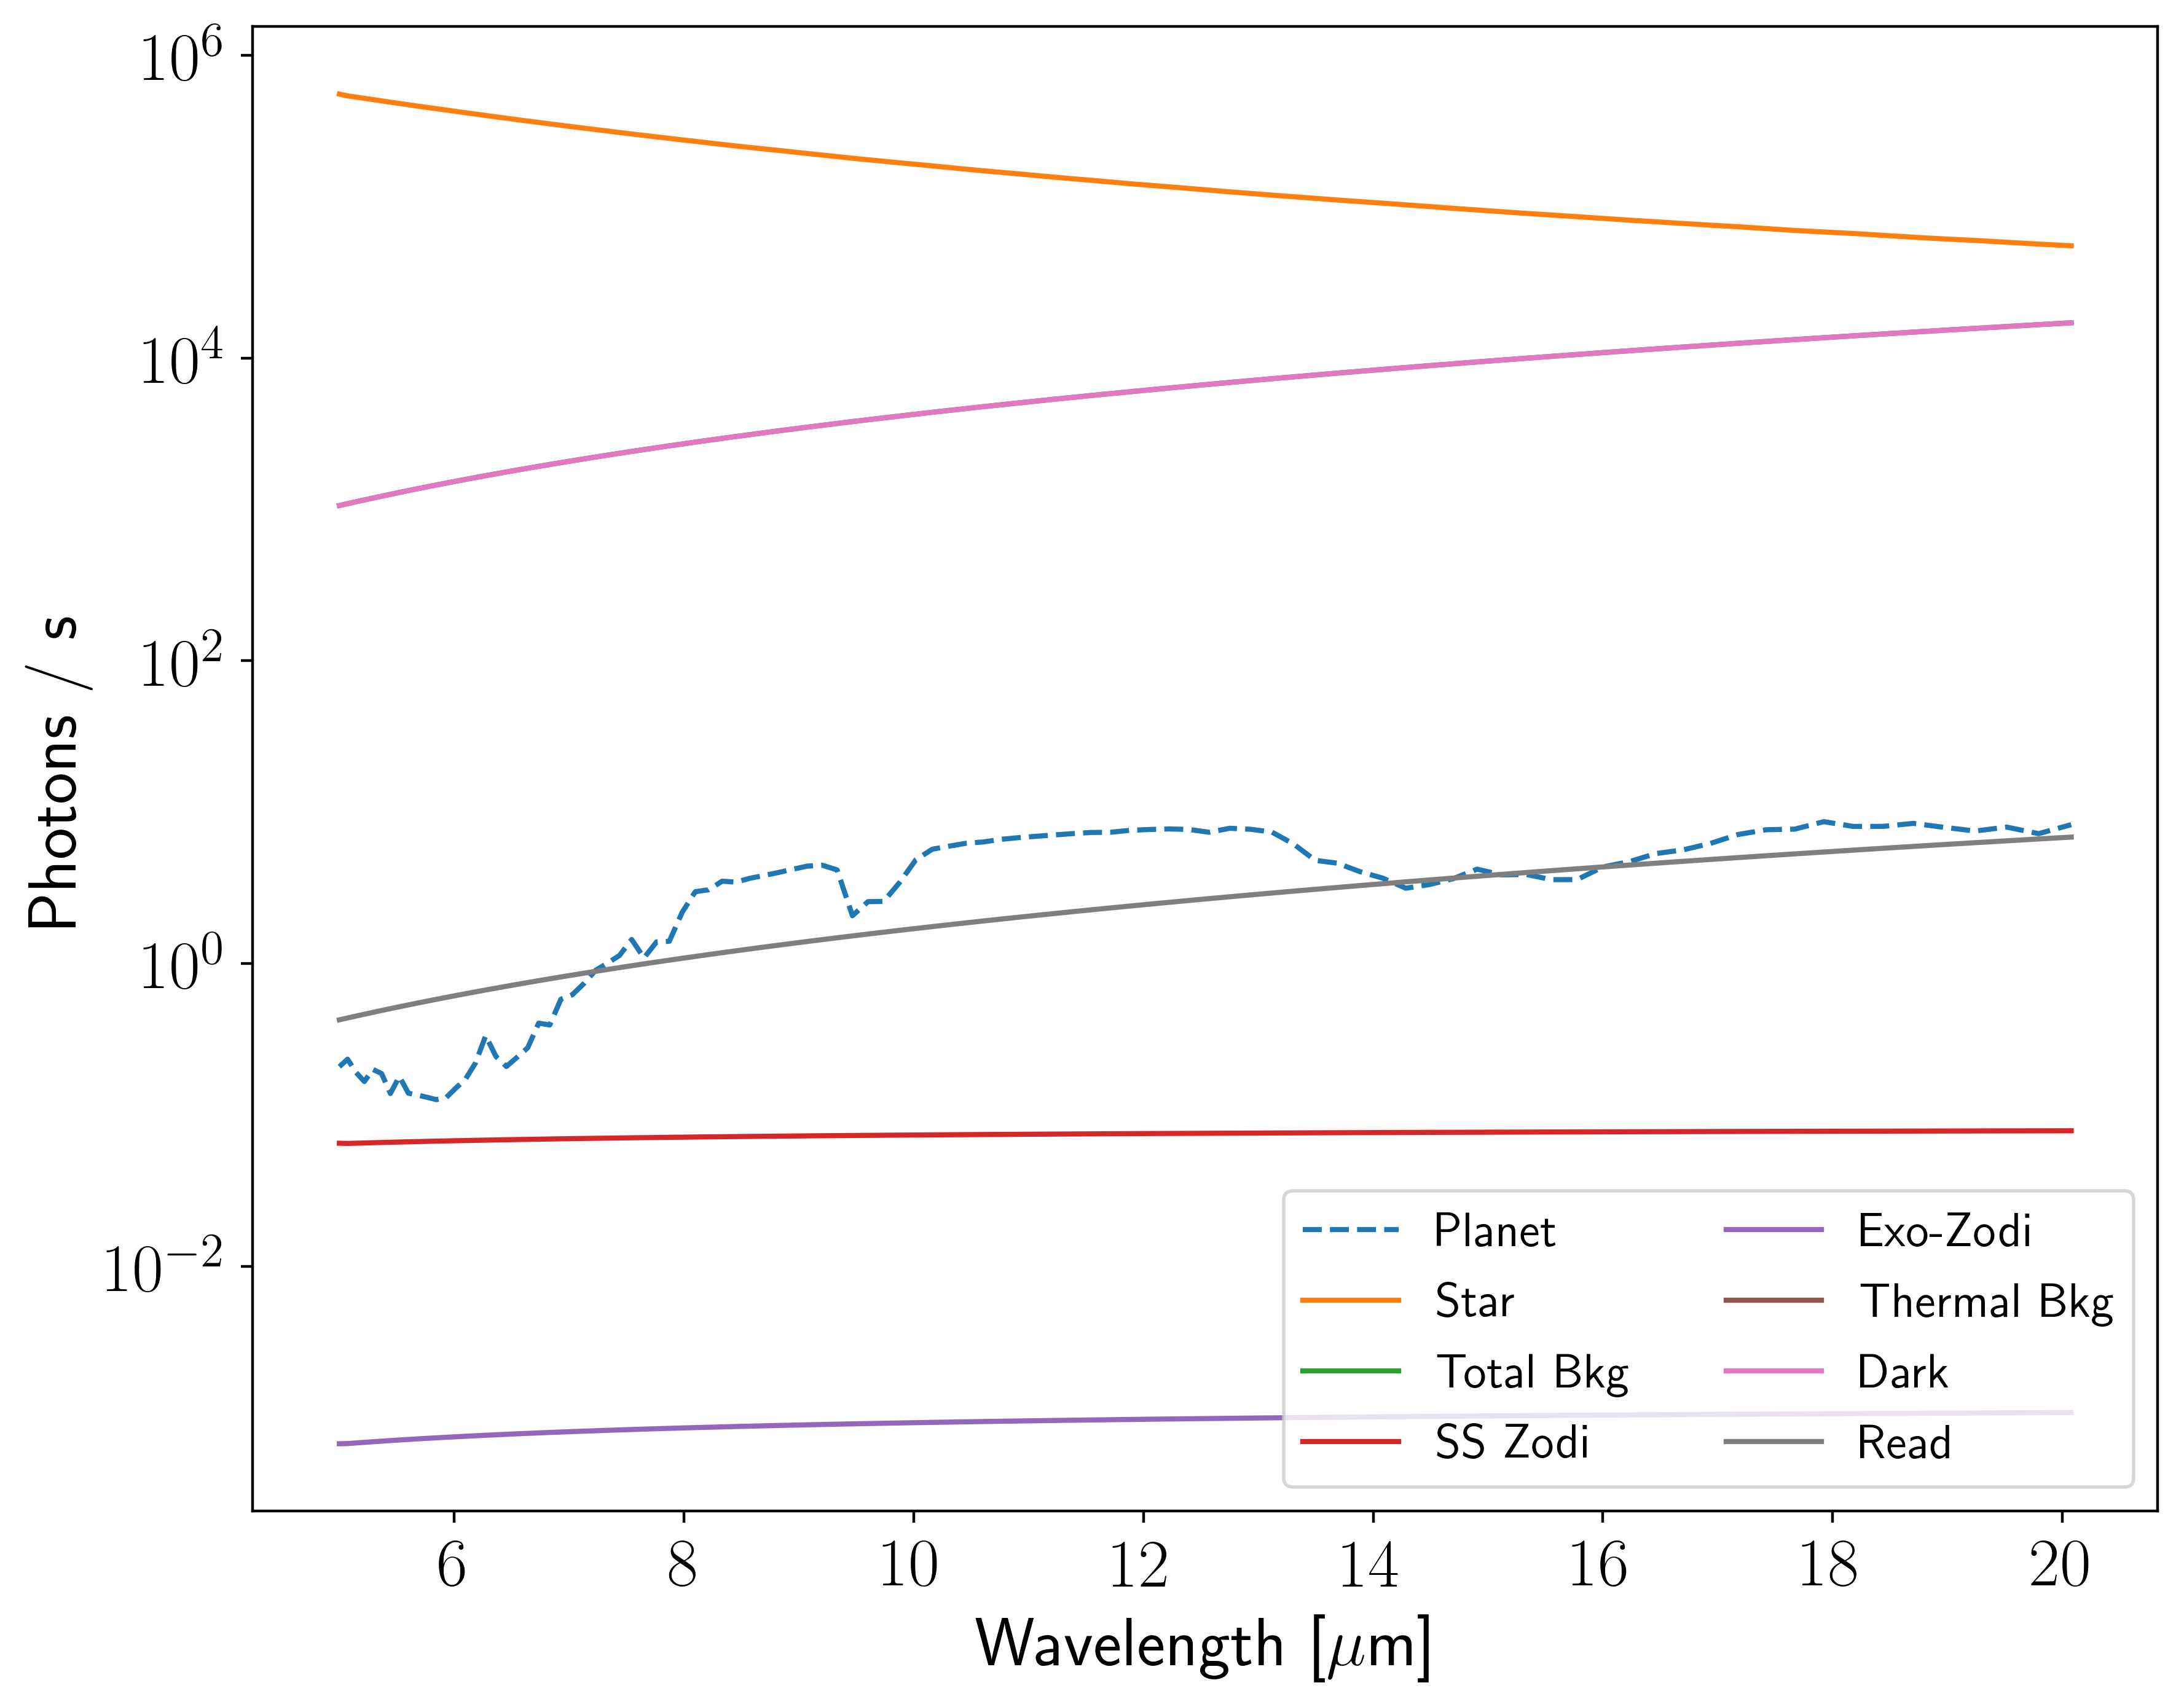

In [22]:
fig, ax = enm.plot_count_rates()

Now the contrast is  ${\sim} 100 \times$ more favorable than the Earth-Sun system. These systems are by no means easy to study, but they are something that we can work with!